<h1> Example Analysis Code For Golden Run03 MAT File </h1>

In [1]:
from numpy import *
import scipy
import pylab
import matplotlib.pyplot as plt # plotting libraries from matlab
from scipy.stats import multivariate_normal
from dateutil import parser
import matplotlib.dates as md
import scipy.io as sio
from scipy.optimize import curve_fit # for fitting
from __future__ import division #otherwise 1/73 = 0 in python2
import pandas as pd

#Aaron's libs
import sys
sys.path.insert(2, '//global/project/projectdirs/lux/data')
import aLib

In [2]:
%pylab inline  
#always do this for matplotlib plotting...  
#and set the size of figures to display in window
pylab.rcParams['figure.figsize'] = (12.0, 8.0) # set size of figures

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


<h1> Load in the Golden Run03 matfile created from root_numpy. About 1.1 GB </h1>

In [3]:
data=sio.loadmat('/project/projectdirs/lux/data/golden/mat/Golden_Run03.mat')
#list of other available files in the /golden/mat directory:
#2013_XeAct_Golden.mat  Golden_CH3T_Aug2013.mat  Golden_Cs137_Aug2013.mat     Golden_Run03.mat  post_DD_2013_Golden.mat
#DD_2013_Golden.mat     Golden_CH3T_Dec2013.mat  Golden_Cs137_Run04-2015.mat  Golden_Run04.mat

<h1> Convert dictionary to structure using Aaron's awesome code. And list rqs </h1>

In [4]:
S=aLib.S(data)

In [5]:
#check what is available
data.keys()

['sd_Rsup',
 'corrected_y',
 'corrected_x',
 's1xyz_correction',
 's1area_raw',
 's1eFitTauFall',
 's2_rec_cor',
 's1area',
 'elife_correction',
 'luxstamp',
 'radius',
 'taxy_y',
 'taxy_x',
 'partner',
 'badArea',
 'sd_Rinf',
 'correctedRadius',
 'q2',
 's2',
 's1',
 's2eFitTauFall',
 's2xy_correction',
 's2pf',
 'taxy_x_cor',
 'spikyS1_raw',
 '__version__',
 's2area_bot_raw',
 's2xy_correction_bot',
 'taxy_correctedRadius',
 'goodArea',
 'excluded',
 'taxy_radius',
 'drift',
 'close2End',
 'tb_asymmetry',
 's2_gaus_fit_chisq',
 's2_rms_width_samples',
 's2_gaus_fit_dof',
 'new_drift',
 's2area',
 'zdrift',
 'se_before_s1',
 'dof',
 '__header__',
 '__globals__',
 's2area_bot',
 's2area_raw',
 'spikyS2',
 'taxy_xy_sigma',
 'y',
 'x',
 's1pf',
 'sdPhi',
 'spikyS2_raw',
 'taxy_y_cor',
 'spikyS1']

In [6]:
S.s1area.size

5504082

<h1> Plot S1 vs S2 ... Doke Plot 101... same as ROOT version in AnalysisCode/ </h1>

In [7]:
#Run03 Golden->Platinum cuts
fid_vol=(aLib.inrange(S.drift,[35, 308]) & (S.correctedRadius<20))
area_cut=aLib.inrange(S.s1area,[10**1,10**4]) & (S.s2area_raw>150) & aLib.inrange(S.s2area,[10**2,10**6])
bad_area_cut=((S.goodArea<=630 & (S.badArea < 80)) | ( (S.goodArea>630) & (S.badArea < 80+0.095*(S.goodArea-630))) )
exclusion_cut=(S.partner==0) & (S.excluded==0)

golden_cut=fid_vol&area_cut&bad_area_cut&exclusion_cut

/anaconda2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


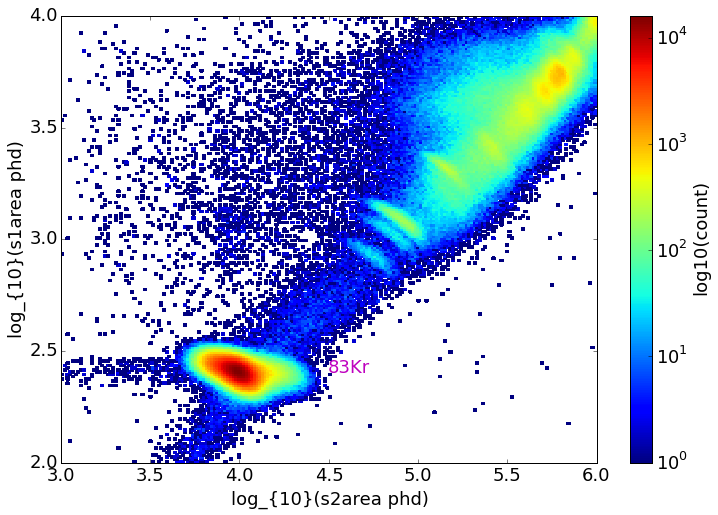

In [8]:
figure=aLib.plot2d(log10(S.s2area[golden_cut]),log10(S.s1area[golden_cut]),[3,6],[2,4],200,200,'log10')

pylab.xlabel('log_{10}(s2area phd)')
pylab.ylabel('log_{10}(s1area phd)')
cc=pylab.colorbar()
cc.set_label('log10(count)',fontsize=18)

plt.rcParams.update({'font.size': 18}) #set all fontsizes to 18

plt.text(4.5,2.4,'83Kr',fontsize=18,color='m')

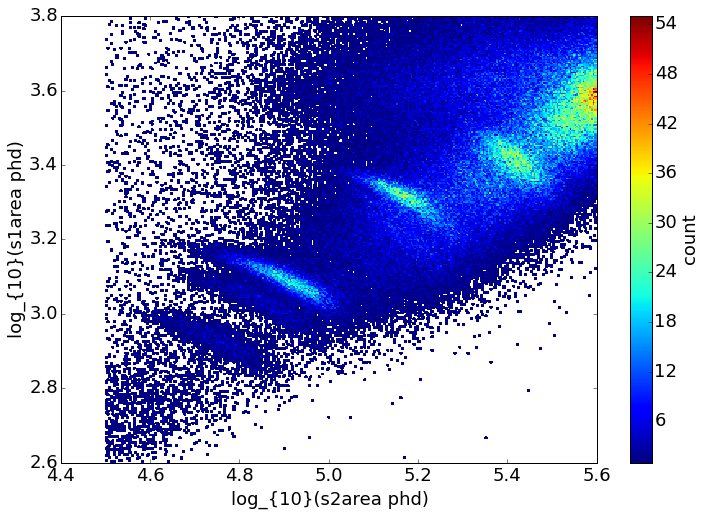

In [14]:
figure=aLib.plot2d(log10(S.s2area[golden_cut]),log10(S.s1area[golden_cut]),[4.5,5.6],[2.6,3.8],300,300)

pylab.xlabel('log_{10}(s2area phd)')
pylab.ylabel('log_{10}(s1area phd)')
cc=pylab.colorbar()
cc.set_label('count',fontsize=18)

plt.rcParams.update({'font.size': 18}) #set all fontsizes to 18


#plt.text(4.5,2.4,'83Kr',fontsize=18,color='m')

<h1> define energies and cuts ... taken from root example </h1>

In [15]:
Energies=[5.2,41.55,163.9,207,236.8,410,609,661.6]
NamesE=["5keV","83Kr-42","164","207","237","410","609","662"]
cutsx=[[log10(1400),log10(1400),log10(2600),log10(2600)],
           [3.6,3.6,4.4,4.4],
           [4.6,4.6,4.9,4.9], 
           [4.7,4.7,4.95,4.95], 
           [4.7,4.7,5.05,5.05], 
           [5.02,5.02,5.3,5.25], 
           [5.3,5.3,5.5,5.5],
           [5.55,5.35,5.4,5.6]]

cutsy=[[1,log10(40),log10(40),1],
           [2.2,2.6,2.6,2.2],
           [2.9,3.1,2.9,2.8], 
           [3.05,3.15,3.0,2.9], 
           [3.1,3.25,3.1,2.95], 
           [3.35, 3.5, 3.3, 3.2], 
           [3.4,3.63,3.43,3.25],
           [3.25,3.5,3.6,3.4]]

mean_s2=zeros(len(Energies))
mean_s2_sig=zeros(len(Energies))
mean_s1=zeros(len(Energies))
mean_s1_sig=zeros(len(Energies))

<h1> make a diagonal cut to isolate the islands of constant energy, 237 keV line </h1>

In [16]:
f1=polyfit([cutsx[4][0],cutsx[4][3]],[cutsy[4][0],cutsy[4][3]],1)
f2=polyfit([cutsx[4][1],cutsx[4][2]],[cutsy[4][1],cutsy[4][2]],1)

In [17]:
cut_237 = (log10(S.s1area)>=polyval(f1,log10(S.s2area))) & (log10(S.s1area)<=polyval(f2,log10(S.s2area))) & aLib.inrange(log10(S.s2area),[min(cutsx[4]),max(cutsx[4])])

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater_equal
  if __name__ == '__main__':
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: RuntimeWarning: invalid value encountered in less_equal
  if __name__ == '__main__':
//global/project/projectdirs/lux/data/aLib/misc.py:520: RuntimeWarning: invalid value encountered in greater_equal
  cut = (a >= a_min) & (a < a_max)
//global/project/projectdirs/lux/data/aLib/misc.py:520: RuntimeWarning: invalid value encountered in less
  cut = (a >= a_min) & (a < a_max)


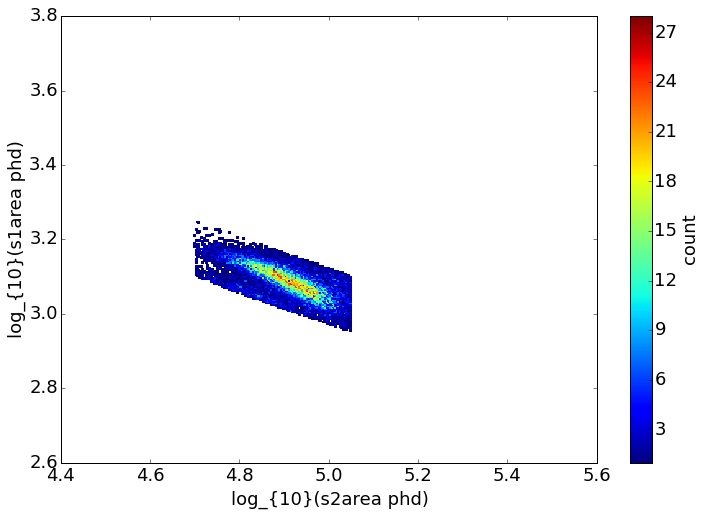

In [18]:
figure=aLib.plot2d(log10(S.s2area[cut_237&golden_cut]),log10(S.s1area[cut_237&golden_cut]),[4.5,5.6],[2.6,3.8],300,300)

pylab.xlabel('log_{10}(s2area phd)')
pylab.ylabel('log_{10}(s1area phd)')
cc=pylab.colorbar()
cc.set_label('count',fontsize=18)

plt.rcParams.update({'font.size': 18}) #set all fontsizes to 18

<h1> Plot a 2D normal distribution to the data to extract the means </h1>

In [19]:
#define 2D normal fitting here:

import scipy.optimize as opt
import numpy as np

def twoD_Gaussian((x, y), amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()

In [20]:
s2=S.s2area[cut_237&golden_cut]
s1=S.s1area[cut_237&golden_cut]

H, xedges, yedges = histogram2d(s2, s1, bins=20, range=None, normed=False)
H=H.T
x_bin_center=(xedges[:-1]+xedges[1:])/2
y_bin_center=(yedges[:-1]+yedges[1:])/2

initial_guess = (H.max(), mean(s2), mean(s1), std(s2), std(s1),0,0)
x, y = np.meshgrid(x_bin_center, y_bin_center)

popt, pcov = opt.curve_fit(twoD_Gaussian, (x, y), H.ravel(), p0=initial_guess)

mean_s2=popt[1]
mean_s2_sig=sqrt(pcov[1,1])
mean_s1=popt[2]
mean_s1_sig=sqrt(pcov[2,2])

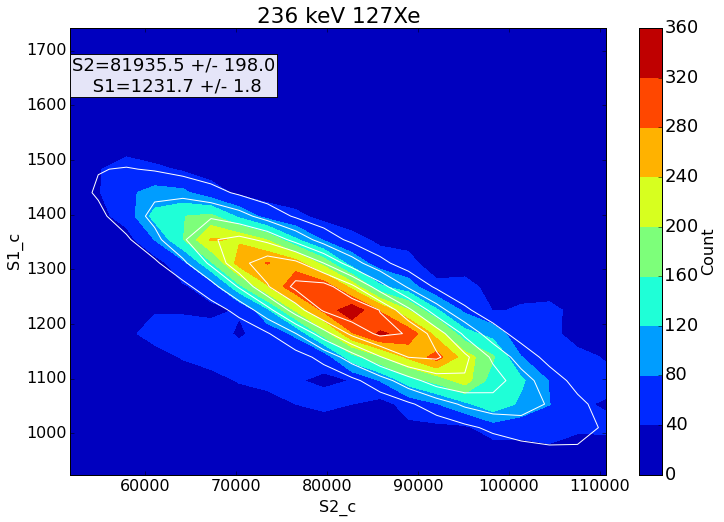

In [21]:
data_fitted = twoD_Gaussian((x, y), *popt)
figure
fig, ax = plt.subplots(1,1)
ax.hold(True)
#ax.imshow(H.reshape(x.shape), cmap=plt.cm.jet, origin='bottom',
#    extent=(x.min(), x.max(), y.min(), y.max()))
plt.contourf(x_bin_center,y_bin_center,H,10)
ax.contour(x, y, data_fitted.reshape(x.shape), 7, colors='w')
plt.xlabel('S2_c',fontsize=16)
plt.ylabel('S1_c',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
cb=plt.colorbar()
cb.set_label('Count',fontsize=16)
plt.text(x.min()*1.22,y.max()*.95,'S2={:1.1f} +/- {:1.1f} \n S1={:1.1f} +/- {:1.1f}'.format(popt[1],sqrt(pcov[1,1]),popt[2],sqrt(pcov[2,2])),
         horizontalalignment='center', verticalalignment='center', bbox=dict(facecolor='w', alpha=0.9),fontsize=18)
plt.title('236 keV 127Xe')
savefig('Xe127_236keV.pdf')

<h1> Make an energy histogam </h1>

In [22]:
fid_vol=(aLib.inrange(S.drift,[35, 308]) & (S.correctedRadius<20))
area_cut=aLib.inrange(S.s1area,[0,10**4]) & (S.s2area_raw>150) & aLib.inrange(S.s2area,[10**2,10**6])
bad_area_cut=((S.goodArea<=630 & (S.badArea < 80)) | ( (S.goodArea>630) & (S.badArea < 80+0.095*(S.goodArea-630))) )
exclusion_cut=(S.partner==0) & (S.excluded==0)

golden_cut=fid_vol&area_cut&bad_area_cut&exclusion_cut

In [23]:
g1=0.1167
g2=12.05

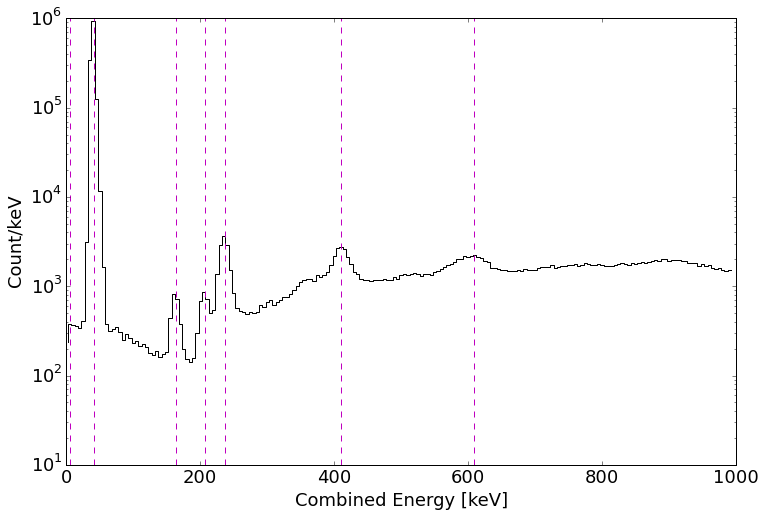

In [24]:
s2=S.s2area[golden_cut]
s1=S.s1area[golden_cut]

E_com=1/73*(s1/g1+s2/g2)
n, xedges = histogram(E_com,arange(0,1000,5))
bin_center=(xedges[1:]+xedges[:-1])/2

plt.step(bin_center,n,'k')
plt.yscale('log')
plt.ylabel('Count/keV')
plt.xlabel('Combined Energy [keV]')
plt.rcParams.update({'font.size': 18}) #increase all fontsizes

Energies=[5.2,41.55,163,207,236.8,410,609]
for ii, En in enumerate(Energies):
    plt.plot([En,En],[10,1e6],'--m')

#ylim([10,5e5])
#plt.legend(('Golden-Doke'))

<h1> plot low E region... use spikyS1 below 100 phd ... 2.7 keV?? </h1>

In [219]:
fid_vol=(aLib.inrange(S.drift,[35, 308]) & (S.correctedRadius<22))
area_cut=aLib.inrange(S.spikyS1,[0.5,150]) & aLib.inrange(S.s1area,[0.5,10**3]) & (S.s2area_raw>150) & aLib.inrange(S.s2area,[100,10**4])
bad_area_cut=((S.goodArea<=630 & (S.badArea < 80)) | ( (S.goodArea>630) & (S.badArea < 80+0.095*(S.goodArea-630))) )
exclusion_cut=(S.partner==0) & (S.excluded==0)

golden_cut=fid_vol&area_cut&bad_area_cut&exclusion_cut

In [223]:
#Gaussian function
def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

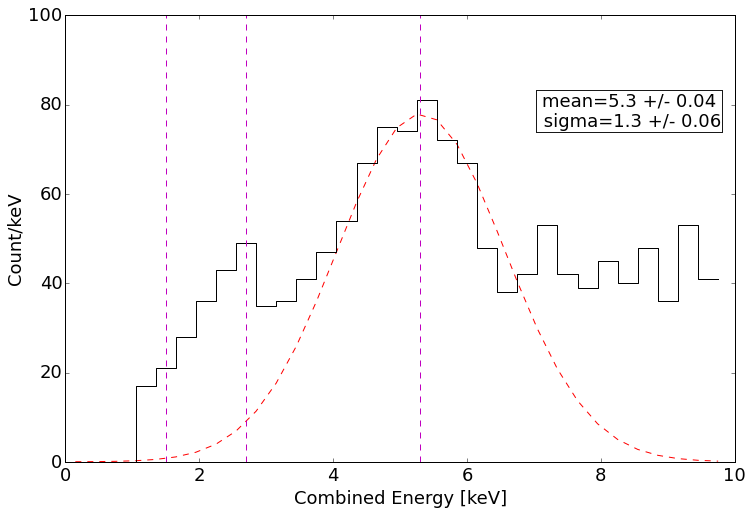

In [253]:
s2=S.s2area[golden_cut]
s1=S.spikyS1[golden_cut]

E_com=1/73*(s1/g1+s2/g2)
n, xedges = histogram(E_com,arange(0,10,0.3))
bin_center=(xedges[1:]+xedges[:-1])/2

#fit a gaussian around the 5.3 keV x-ray from Xe127
fitcut=aLib.inrange(bin_center,[3.5,7])
popt, pcov = curve_fit(gauss_function, bin_center[fitcut],n[fitcut],p0 = [1, mean(E_com), std(E_com)])
plt.plot(bin_center,gauss_function(bin_center, *popt),'--r')
plt.text(xedges.max()*.85,n.max()*.97,'mean={:1.1f} +/- {:1.2f} \n sigma={:1.1f} +/- {:1.2f}'.format(popt[1],sqrt(pcov[1,1]),popt[2],sqrt(pcov[2,2])),
         horizontalalignment='center', verticalalignment='center', bbox=dict(facecolor='w', alpha=0.9),fontsize=18)

plt.step(bin_center,n,'k')
#plt.yscale('log')
plt.ylabel('Count/keV')
plt.xlabel('Combined Energy [keV]')
plt.rcParams.update({'font.size': 18}) #increase all fontsizes

Energies=[1.5,2.7,5.3]
for ii, En in enumerate(Energies):
    plt.plot([En,En],[0,100],'--m')

<h1> Get LUX Stamps </h1>

In [254]:
S.luxstamp[golden_cut] #... add Energy cut, radial cut or whatever...

array([7288653504762489, 7297279180618365, 7297299218222263, ...,
       8420618779635610, 8420937285593109, 8420953493185027], dtype=uint64)